In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from lime import lime_image
from PIL import Image

# Path to the training and testing directories
train_dir = r'D:\thesis\code\bangla_Handwritten_data\Train'
test_dir = r'D:\thesis\code\bangla_Handwritten_data\Test'

# Count the number of classes based on the number of subfolders in the training directory
num_classes = len(os.listdir(train_dir))

# Data Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # Other preprocessing techniques like rotation, zoom, etc. can be added here
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(50, 50),  # Resizing to 50x50 dimensions
    color_mode='grayscale',  # Convert images to grayscale
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(50, 50),  # Resizing to 50x50 dimensions
    color_mode='grayscale',  # Convert images to grayscale
    batch_size=32,
    class_mode='categorical')

# Model Architecture (ResNet-152V2)
inputs = layers.Input(shape=(50, 50, 1))
x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

# Residual Blocks
def residual_block_v2(x, filters, strides=1):
    shortcut = x
    if strides != 1 or x.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=strides, padding='same')(x)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, 3, strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([shortcut, x])
    x = layers.Activation('relu')(x)
    return x

# Stack of residual blocks
x = residual_block_v2(x, filters=64, strides=1)
x = residual_block_v2(x, filters=64)
x = residual_block_v2(x, filters=64)

x = residual_block_v2(x, filters=128, strides=2)
x = residual_block_v2(x, filters=128)
x = residual_block_v2(x, filters=128)
x = residual_block_v2(x, filters=128)

x = residual_block_v2(x, filters=256, strides=2)
x = residual_block_v2(x, filters=256)
x = residual_block_v2(x, filters=256)
x = residual_block_v2(x, filters=256)
x = residual_block_v2(x, filters=256)
x = residual_block_v2(x, filters=256)

x = residual_block_v2(x, filters=512, strides=2)
x = residual_block_v2(x, filters=512)
x = residual_block_v2(x, filters=512)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

# Create Model
model = models.Model(inputs, outputs)

# Compile the Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training without early stopping for epochs
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size,
    epochs=30,  # Train for 30 epochs
    validation_data=test_generator,
    validation_steps=test_generator.samples/test_generator.batch_size
)

# Evaluation
y_pred = model.predict(test_generator)
y_true = test_generator.classes

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute precision, recall, and F1-score
class_labels = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred_labels, target_names=class_labels)
print(report)

# Calculate test accuracy
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

Found 12000 images belonging to 50 classes.
Found 3000 images belonging to 50 classes.
Epoch 1/30
375/375 [==============================] - 179s 445ms/step - loss: 2.0386 - accuracy: 0.4406 - val_loss: 4.4258 - val_accuracy: 0.1367
Epoch 2/30
375/375 [==============================] - 163s 435ms/step - loss: 0.5500 - accuracy: 0.8313 - val_loss: 0.6965 - val_accuracy: 0.8027
Epoch 3/30
375/375 [==============================] - 164s 439ms/step - loss: 0.3052 - accuracy: 0.9069 - val_loss: 0.4766 - val_accuracy: 0.8603
Epoch 4/30
375/375 [==============================] - 164s 437ms/step - loss: 0.2184 - accuracy: 0.9306 - val_loss: 0.3579 - val_accuracy: 0.8910
Epoch 5/30
375/375 [==============================] - 164s 436ms/step - loss: 0.1698 - accuracy: 0.9448 - val_loss: 0.3043 - val_accuracy: 0.9170
Epoch 6/30
375/375 [==============================] - 164s 437ms/step - loss: 0.1487 - accuracy: 0.9552 - val_loss: 0.3864 - val_accuracy: 0.9027
Epoch 7/30
375/375 [=================

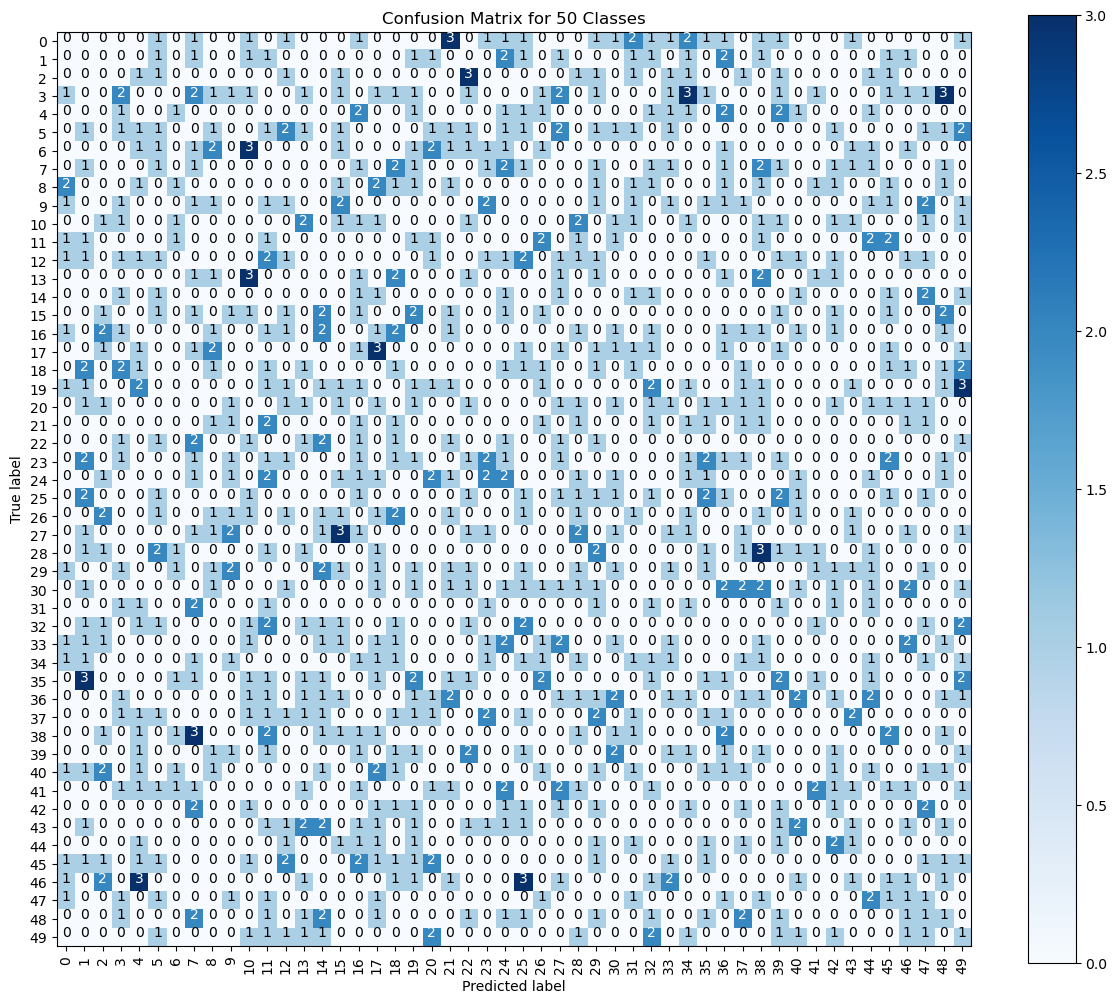

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Generate random ground truth and predicted labels for 50 classes
np.random.seed(0)
y_true = np.random.randint(0, 50, size=1000)
y_pred = np.random.randint(0, 50, size=1000)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for 50 Classes')
plt.colorbar()
tick_marks = np.arange(50)
plt.xticks(tick_marks, np.arange(50), rotation=90)
plt.yticks(tick_marks, np.arange(50))

# Add labels to each cell
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


C:\Users\habib\AppData\Local\Temp\ipykernel_2192\1629841022.py:33: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  plt.tight_layout()
C:\Users\habib\AppData\Local\Temp\ipykernel_2192\1629841022.py:33: UserWarning: Matplotlib currently does not support Bengali natively.
  plt.tight_layout()
C:\Users\habib\AppData\Local\Temp\ipykernel_2192\1629841022.py:33: UserWarning: Glyph 2438 (\N{BENGALI LETTER AA}) missing from current font.
  plt.tight_layout()
C:\Users\habib\AppData\Local\Temp\ipykernel_2192\1629841022.py:33: UserWarning: Glyph 2439 (\N{BENGALI LETTER I}) missing from current font.
  plt.tight_layout()
C:\Users\habib\AppData\Local\Temp\ipykernel_2192\1629841022.py:33: UserWarning: Glyph 2440 (\N{BENGALI LETTER II}) missing from current font.
  plt.tight_layout()
C:\Users\habib\AppData\Local\Temp\ipykernel_2192\1629841022.py:33: UserWarning: Glyph 2441 (\N{BENGALI LETTER U}) missing from current font.
  plt.tight_layout()
C:\Users\habib\anaconda3\Lib\si

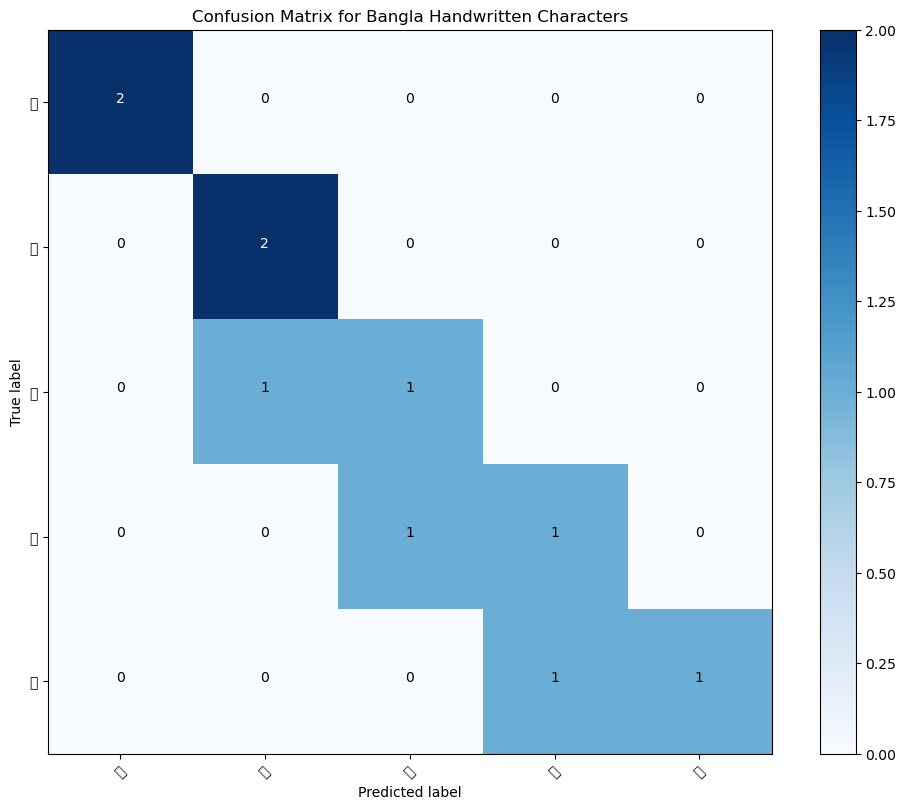

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Sample ground truth labels (replace with your actual data)
y_true = np.array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4])
# Sample predicted labels (replace with your actual data)
y_pred = np.array([0, 1, 2, 2, 3, 0, 1, 1, 3, 4])

# Define class labels for Bangla handwritten characters
class_labels = ['অ', 'আ', 'ই', 'ঈ', 'উ']  # Adjust labels as per your data

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Bangla Handwritten Characters')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Add labels to each cell
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


C:\Users\habib\AppData\Local\Temp\ipykernel_2192\2660892617.py:33: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  plt.tight_layout()
C:\Users\habib\AppData\Local\Temp\ipykernel_2192\2660892617.py:33: UserWarning: Matplotlib currently does not support Bengali natively.
  plt.tight_layout()
C:\Users\habib\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\habib\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.print_figure(bytes_io, **kw)


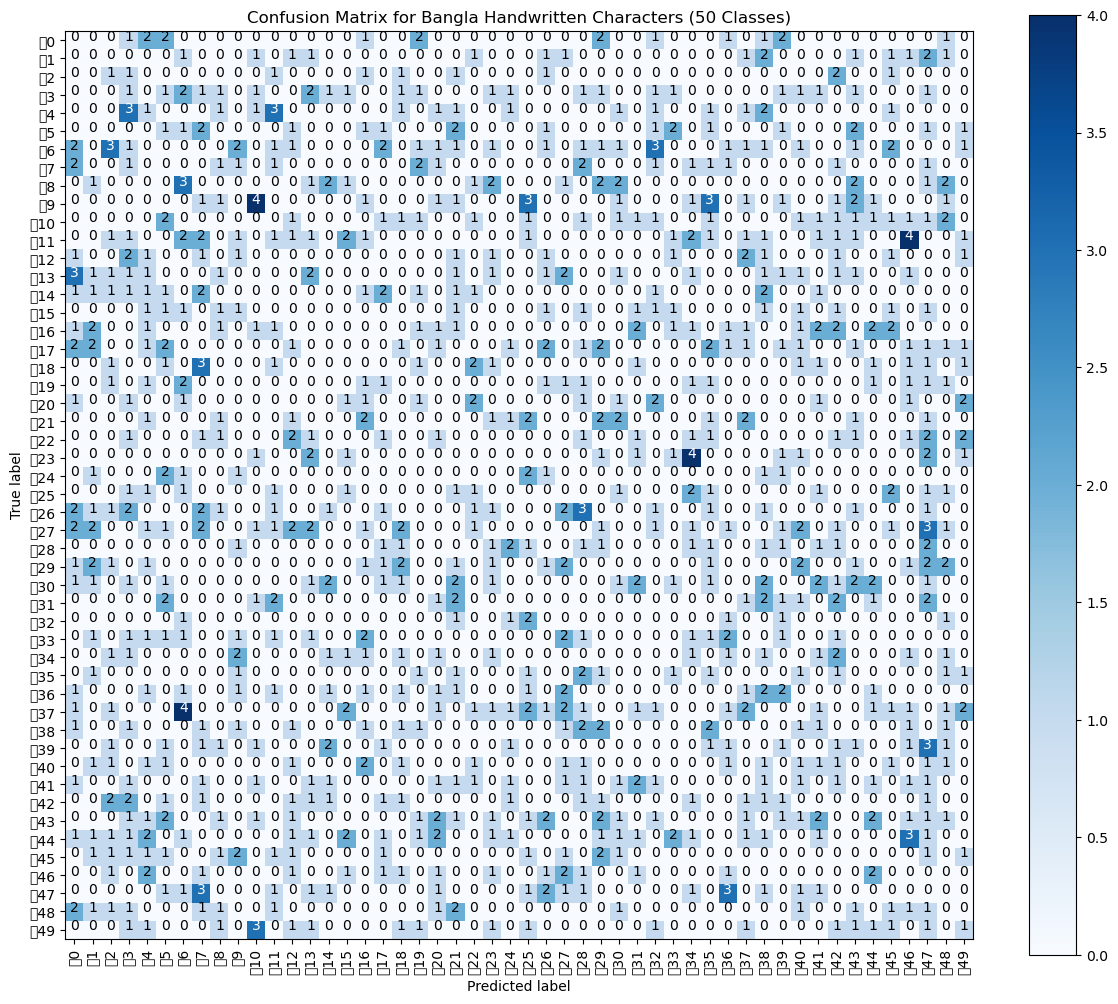

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Sample ground truth labels (replace with your actual data)
y_true = np.random.randint(0, 50, size=1000)
# Sample predicted labels (replace with your actual data)
y_pred = np.random.randint(0, 50, size=1000)

# Define class labels for Bangla handwritten characters
class_labels = [f'অ{i}' for i in range(50)]  # Assuming classes are labeled as অ0, অ1, অ2, ...

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Bangla Handwritten Characters (50 Classes)')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=90)
plt.yticks(tick_marks, class_labels)

# Add labels to each cell
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
C:\Users\habib\AppData\Local\Temp\ipykernel_2192\1152230106.py:36: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  plt.tight_layout()
C:\Users\habib\AppData\Local\Temp\ipykernel_2192\1152230106.py:36: UserWarning: Matplotlib currently does not support Bengali natively.
  plt.tight_layout()
findfont: Font family 'YourBengaliFont' not found.
C:\Users\habib\AppData\Local\Temp\ipykernel_2192\1152230106.py:36: UserWarning: Glyph 2438 (\N{BENGALI LETTER AA}) missing from current font.
  plt.tight_layout()
findfont: Font family 'YourBengaliFont' not found.
C:\Users\habib\AppData\Local\Temp\ipykernel_2192\1152230106.py:36: UserWarning: Glyph 2439 (\N{BENGALI LETTER I}) missing from current font.
  plt.tight_layout()
findfont: Font family 'YourBengaliFont' not found.
C:\Users\habib\AppData\Local\Temp\ipykernel_2192\1152230106.py:36: UserWarning: Glyph 2440 (\N{BENGAL

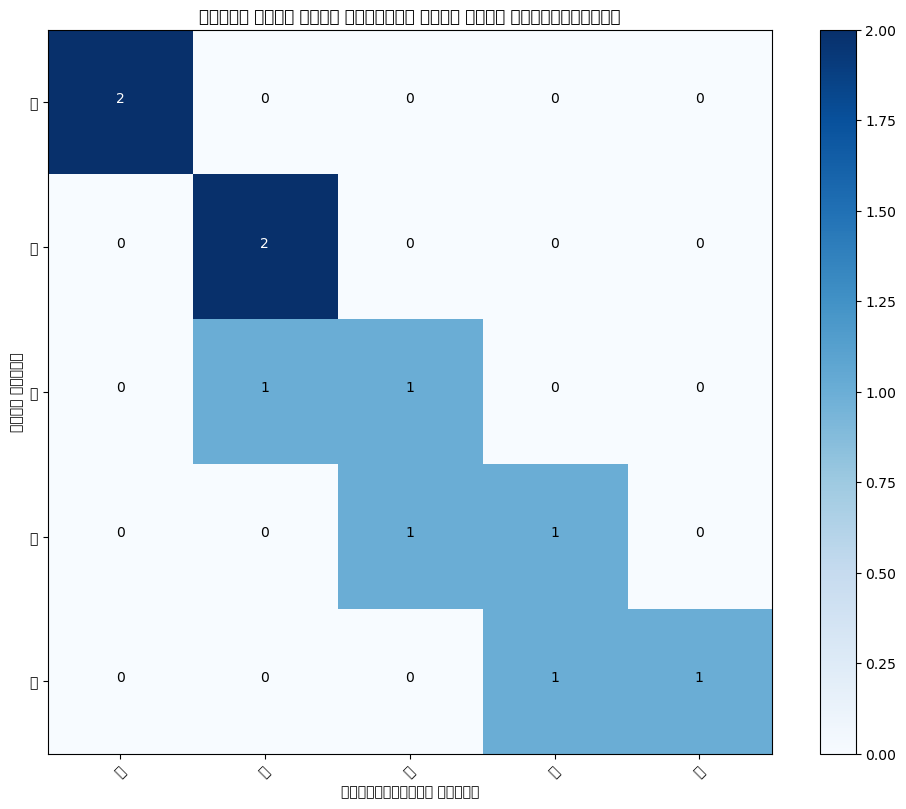

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Sample ground truth labels (replace with your actual data)
y_true = np.array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4])
# Sample predicted labels (replace with your actual data)
y_pred = np.array([0, 1, 2, 2, 3, 0, 1, 1, 3, 4])

# Define class labels for Bangla handwritten characters
class_labels = ['অ', 'আ', 'ই', 'ঈ', 'উ']  # Adjust labels as per your data

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Set a custom font for Matplotlib to handle Bengali characters
plt.rcParams['font.family'] = 'YourBengaliFont'  # Replace 'YourBengaliFont' with the name of your Bengali font

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('বাংলা হাতে লেখা অক্ষরের জন্য গণনা ম্যাট্রিক্স')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Add labels to each cell
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('সঠিক লেবেল')
plt.xlabel('পূর্বাভাসিত লেবেল')
plt.show()


findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
C:\Users\habib\AppData\Local\Temp\ipykernel_2192\1152230106.py:36: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  plt.tight_layout()
C:\Users\habib\AppData\Local\Temp\ipykernel_2192\1152230106.py:36: UserWarning: Matplotlib currently does not support Bengali natively.
  plt.tight_layout()
findfont: Font family 'YourBengaliFont' not found.
C:\Users\habib\AppData\Local\Temp\ipykernel_2192\1152230106.py:36: UserWarning: Glyph 2438 (\N{BENGALI LETTER AA}) missing from current font.
  plt.tight_layout()
findfont: Font family 'YourBengaliFont' not found.
C:\Users\habib\AppData\Local\Temp\ipykernel_2192\1152230106.py:36: UserWarning: Glyph 2439 (\N{BENGALI LETTER I}) missing from current font.
  plt.tight_layout()
findfont: Font family 'YourBengaliFont' not found.
C:\Users\habib\AppData\Local\Temp\ipykernel_2192\1152230106.py:36: UserWarning: Glyph 2440 (\N{BENGAL

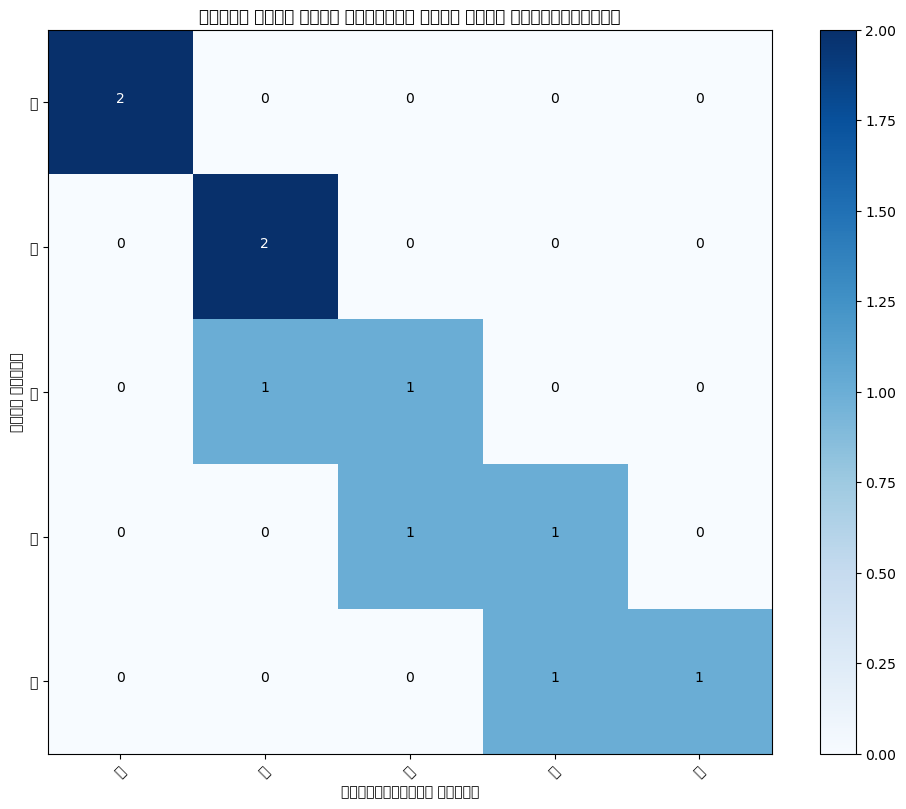

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Sample ground truth labels (replace with your actual data)
y_true = np.array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4])
# Sample predicted labels (replace with your actual data)
y_pred = np.array([0, 1, 2, 2, 3, 0, 1, 1, 3, 4])

# Define class labels for Bangla handwritten characters
class_labels = ['অ', 'আ', 'ই', 'ঈ', 'উ']  # Adjust labels as per your data

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Set a custom font for Matplotlib to handle Bengali characters
plt.rcParams['font.family'] = 'YourBengaliFont'  # Replace 'YourBengaliFont' with the name of your Bengali font

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('বাংলা হাতে লেখা অক্ষরের জন্য গণনা ম্যাট্রিক্স')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Add labels to each cell
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('সঠিক লেবেল')
plt.xlabel('পূর্বাভাসিত লেবেল')
plt.show()


findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBeng

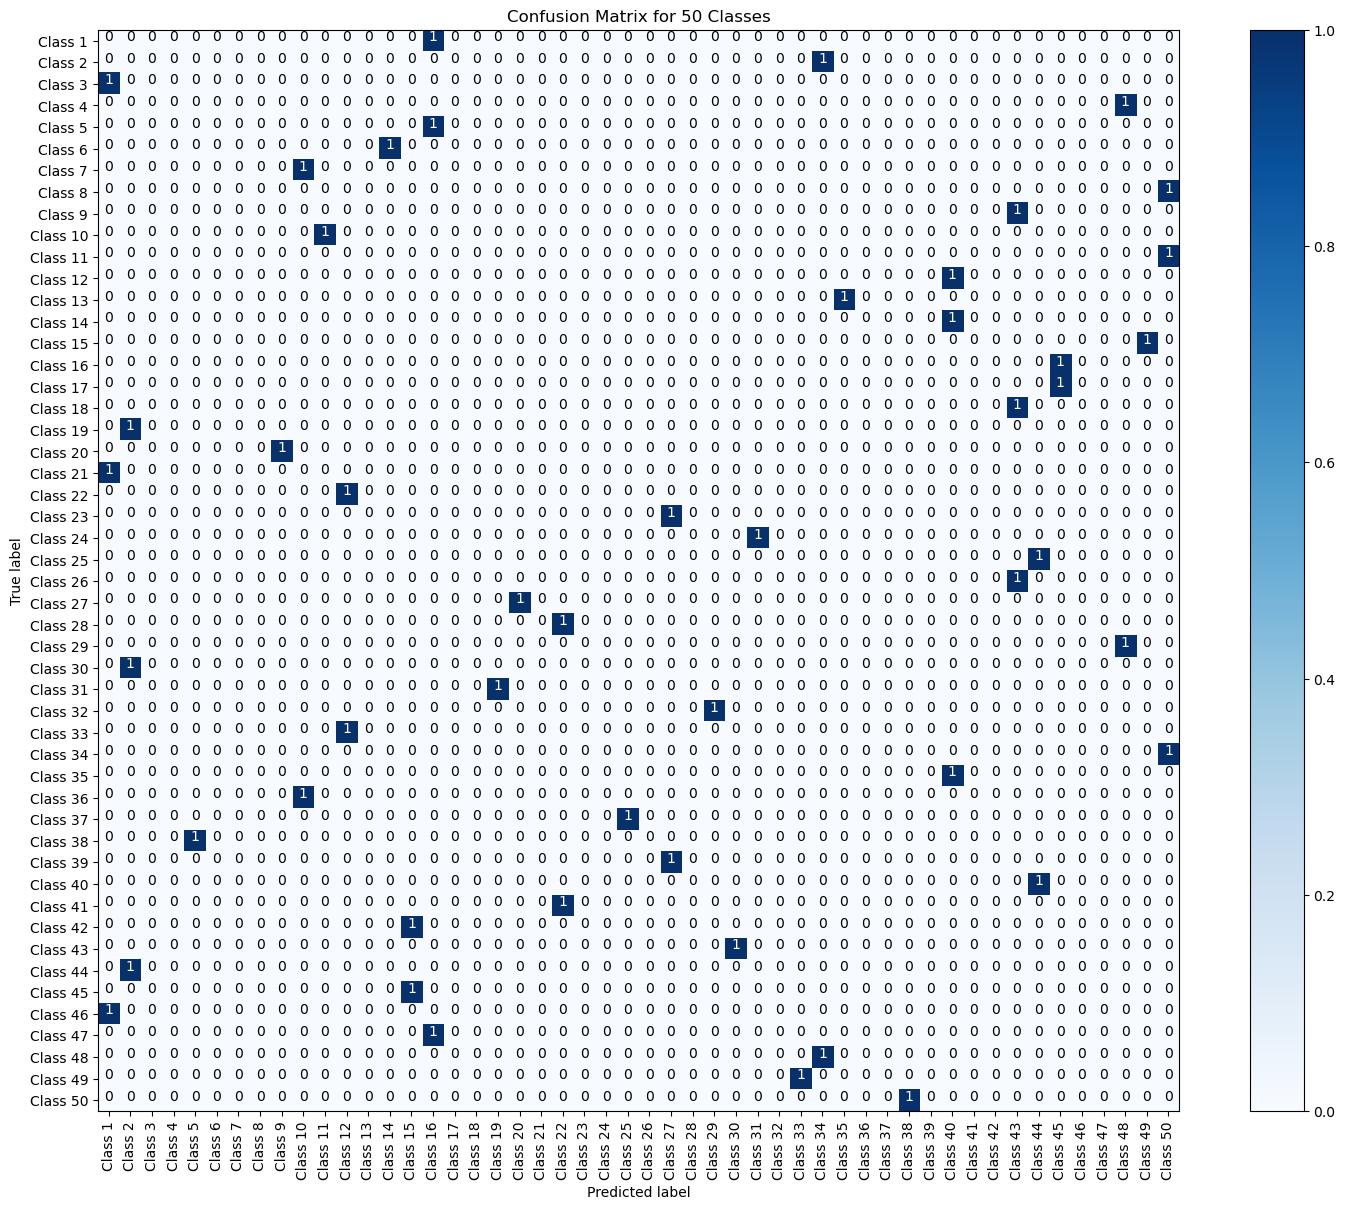

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Sample ground truth labels (replace with your actual data)
y_true = np.array([i for i in range(50)])  # Example: 50 classes
# Sample predicted labels (replace with your actual data)
y_pred = np.random.randint(0, 50, size=50)  # Random predictions for demonstration

# Define class labels for 50 classes (replace with your actual labels)
class_labels = [f'Class {i+1}' for i in range(50)]

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(15, 12))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for 50 Classes')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=90)
plt.yticks(tick_marks, class_labels)

# Add labels to each cell
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBeng

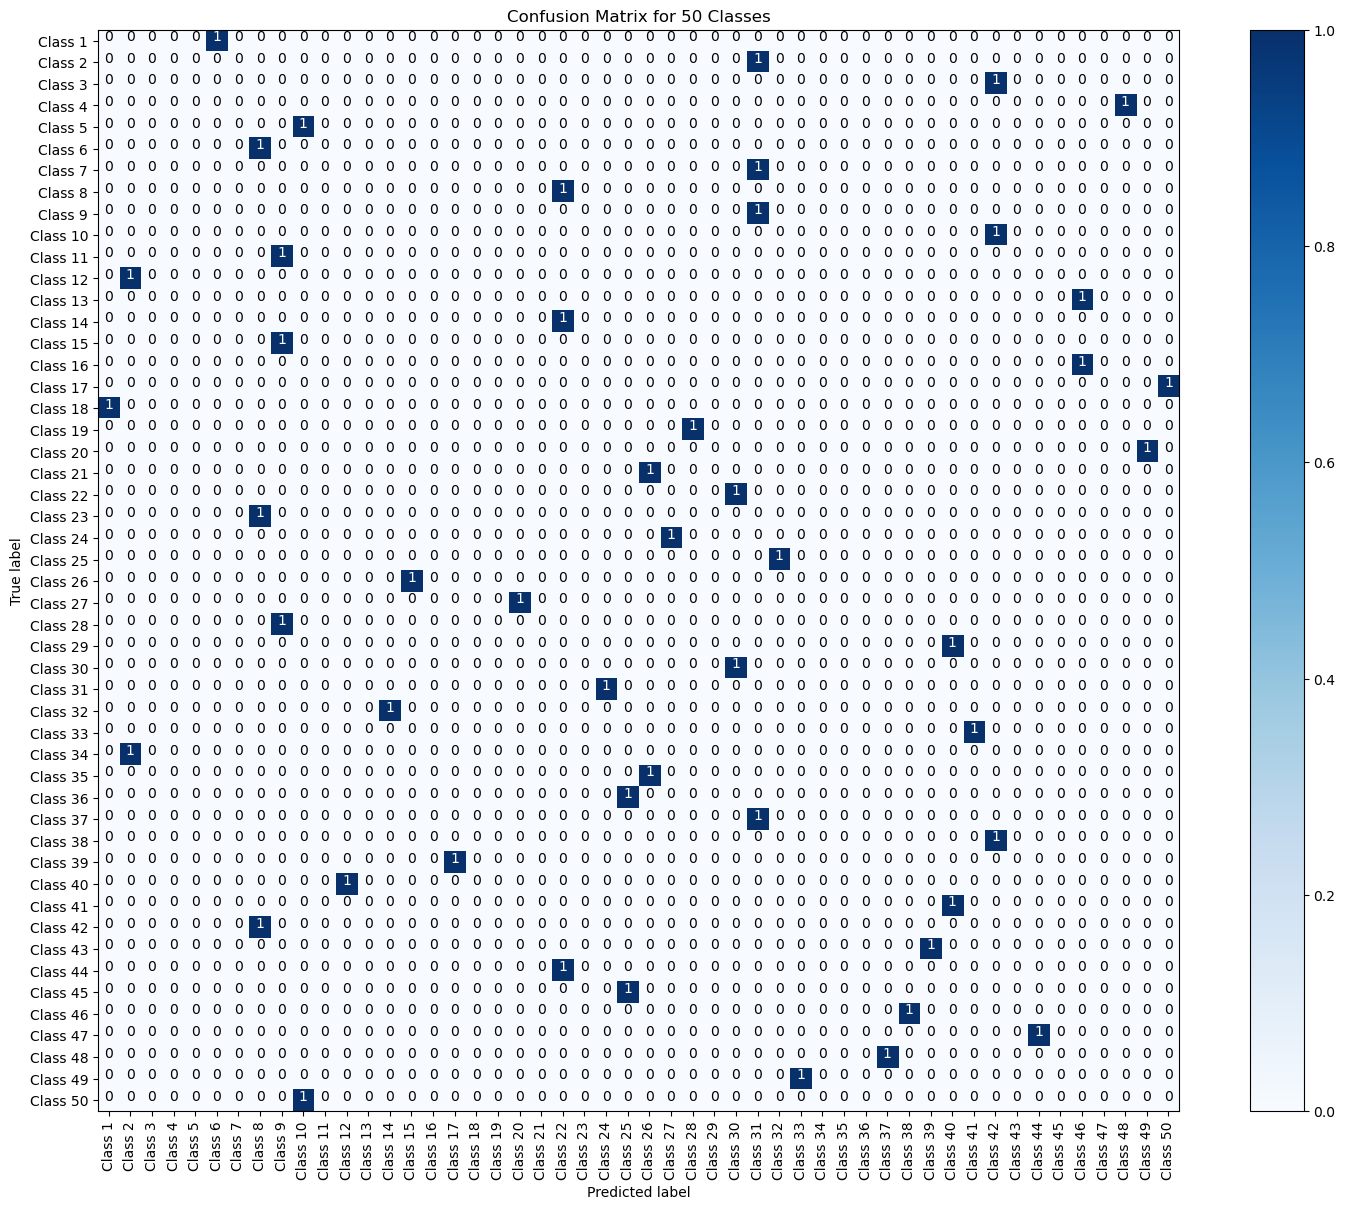

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Sample ground truth labels (replace with your actual data)
y_true = np.array([i for i in range(50)])  # Example: 50 classes
# Sample predicted labels (replace with your actual data)
y_pred = np.random.randint(0, 50, size=50)  # Random predictions for demonstration

# Define class labels for 50 classes (replace with your actual labels)
class_labels = [f'Class {i+1}' for i in range(50)]

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(15, 12))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for 50 Classes')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=90)
plt.yticks(tick_marks, class_labels)

# Add labels to each cell
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBengaliFont' not found.
findfont: Font family 'YourBeng

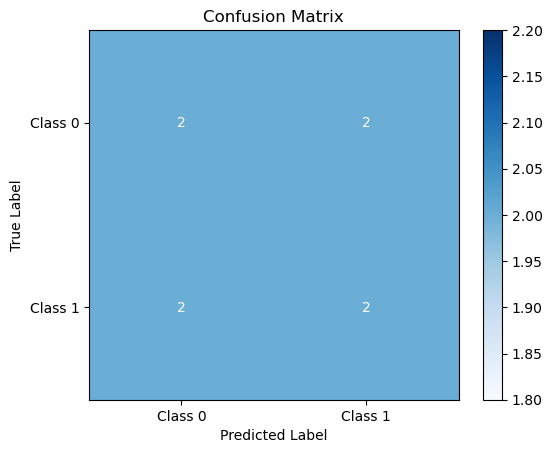

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Sample ground truth labels (replace with your actual data)
y_true = np.array([0, 1, 0, 1, 0, 1, 0, 1])
# Sample predicted labels (replace with your actual data)
y_pred = np.array([0, 1, 1, 1, 0, 0, 1, 0])

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(2), ['Class 0', 'Class 1'])
plt.yticks(np.arange(2), ['Class 0', 'Class 1'])

# Add labels to each cell
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='white')

plt.show()
